 # Table of Contents
<div class="toc" style="margin-top: 1em;"><ul class="toc-item" id="toc-level0"><li><span><a href="http://localhost:8888/notebooks/feature_importance.ipynb#Feature-importance-from-from-linear-model" data-toc-modified-id="Feature-importance-from-from-linear-model-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Feature importance from from linear model</a></span><ul class="toc-item"><li><span><a href="http://localhost:8888/notebooks/feature_importance.ipynb#Train-the-model-and-get-reference-score" data-toc-modified-id="Train-the-model-and-get-reference-score-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Train the model and get reference score</a></span></li><li><span><a href="http://localhost:8888/notebooks/feature_importance.ipynb#Get-random-permutation-scores-and-compute-feature-importance" data-toc-modified-id="Get-random-permutation-scores-and-compute-feature-importance-1.2"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>Get random permutation scores and compute feature importance</a></span></li></ul></li><li><span><a href="http://localhost:8888/notebooks/feature_importance.ipynb#With-embeddings" data-toc-modified-id="With-embeddings-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>With embeddings</a></span><ul class="toc-item"><li><span><a href="http://localhost:8888/notebooks/feature_importance.ipynb#Train-the-model" data-toc-modified-id="Train-the-model-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Train the model</a></span></li><li><span><a href="http://localhost:8888/notebooks/feature_importance.ipynb#Get-feature-importance" data-toc-modified-id="Get-feature-importance-2.2"><span class="toc-item-num">2.2&nbsp;&nbsp;</span>Get feature importance</a></span></li></ul></li><li><span><a href="http://localhost:8888/notebooks/feature_importance.ipynb#Neural-net-with-hidden-layer-and-embeddings" data-toc-modified-id="Neural-net-with-hidden-layer-and-embeddings-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Neural net with hidden layer and embeddings</a></span><ul class="toc-item"><li><span><a href="http://localhost:8888/notebooks/feature_importance.ipynb#Train-the-model" data-toc-modified-id="Train-the-model-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>Train the model</a></span></li><li><span><a href="http://localhost:8888/notebooks/feature_importance.ipynb#Evaluate-feature-importance" data-toc-modified-id="Evaluate-feature-importance-3.2"><span class="toc-item-num">3.2&nbsp;&nbsp;</span>Evaluate feature importance</a></span></li></ul></li><li><span><a href="http://localhost:8888/notebooks/feature_importance.ipynb#Compare-feature-importances" data-toc-modified-id="Compare-feature-importances-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Compare feature importances</a></span></li><li><span><a href="http://localhost:8888/notebooks/feature_importance.ipynb#Why-is-t2m_std-not-important?" data-toc-modified-id="Why-is-t2m_std-not-important?-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Why is t2m_std not important?</a></span><ul class="toc-item"><li><span><a href="http://localhost:8888/notebooks/feature_importance.ipynb#Is-there-a-good-correlation-between-forecast-error-and-raw-ansemble-spread?" data-toc-modified-id="Is-there-a-good-correlation-between-forecast-error-and-raw-ansemble-spread?-5.1"><span class="toc-item-num">5.1&nbsp;&nbsp;</span>Is there a good correlation between forecast error and raw ansemble spread?</a></span></li><li><span><a href="http://localhost:8888/notebooks/feature_importance.ipynb#What-about-the-correlation-between-the-error-and-PP-spread?" data-toc-modified-id="What-about-the-correlation-between-the-error-and-PP-spread?-5.2"><span class="toc-item-num">5.2&nbsp;&nbsp;</span>What about the correlation between the error and PP spread?</a></span></li><li><span><a href="http://localhost:8888/notebooks/feature_importance.ipynb#Does-the-NN-care-at-all-about-the-fc-spread?" data-toc-modified-id="Does-the-NN-care-at-all-about-the-fc-spread?-5.3"><span class="toc-item-num">5.3&nbsp;&nbsp;</span>Does the NN care at all about the fc spread?</a></span></li></ul></li></ul></div>

# Feature importance

The skill of our models certainly increases with auxiliary variables. Of course we would like to know which of the 38 variables we added actually helped the predictions.

Random permutation importance gives us some insight. For this we randomly permute one feature at a time from the test set and evaluate the decrease in skill.


In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
%matplotlib inline
from nn_src.imports import *
from nn_src.utils import get_datasets

Using TensorFlow backend.


In [3]:
#DATA_DIR = '/Users/stephanrasp/data/'
# DATA_DIR = '/scratch/srasp/ppnn_data/'
DATA_DIR = '/Volumes/SanDisk/data/ppnn_data/'

In [4]:
aux_train_set, aux_test_set = get_datasets(DATA_DIR, 'aux_15_16.pkl', ['2015-01-01', '2016-01-01'], aux=True)

In [5]:
n_features = aux_train_set.features.shape[1]; n_features

40

## Feature importance from from linear model

### Train the model and get reference score

In [6]:
fc_aux = build_fc_model(n_features, 2, compile=True, lr=0.02)

In [7]:
fc_aux.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 40)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 2)                 82        
Total params: 82
Trainable params: 82
Non-trainable params: 0
_________________________________________________________________


In [8]:
fc_aux.fit(aux_train_set.features, aux_train_set.targets, 1024, 30, verbose=0)

In [9]:
# Get the reference score from the last model we trained
ref_score = fc_aux.evaluate(aux_test_set.features, aux_test_set.targets, 4096, 0); ref_score

0.92613583435705726

### Get random permutation scores and compute feature importance

In [10]:
def eval_shuf(m, idx, emb=False):
    x_shuf = aux_test_set.features.copy()
    x_shuf[:, idx] = np.random.permutation(x_shuf[:, idx])
    x = [x_shuf, aux_test_set.cont_ids] if emb else x_shuf
    return m.evaluate(x, aux_test_set.targets, 4096, 0)

In [11]:
def perm_imp(m):
    scores = [eval_shuf(m, i) for i in range(len(aux_test_set.feature_names))]
    fimp = np.array(scores) - ref_score
    df = pd.DataFrame(columns=['Feature', 'Importance'])
    df['Feature'] = aux_test_set.feature_names; df['Importance'] = fimp
    return df

In [12]:
fimp_fc_aux = perm_imp(fc_aux)

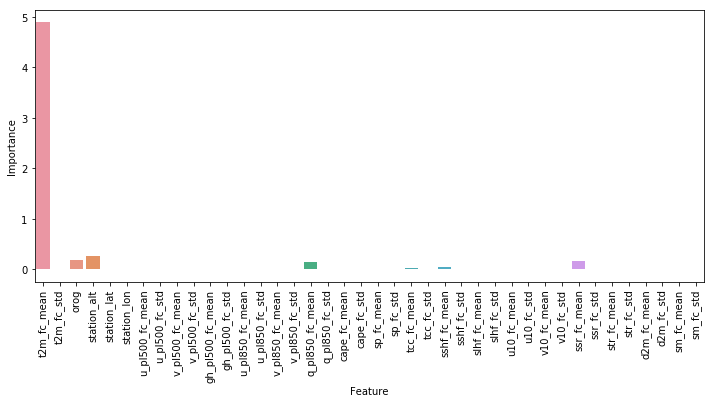

In [13]:
fig, ax = plt.subplots(figsize=(12, 5))
sns.barplot(data=fimp_fc_aux, y='Importance', x='Feature', ax=ax)
plt.xticks(rotation=90);

## With embeddings

### Train the model

In [14]:
emb_size = 2
max_id = int(np.max([aux_train_set.cont_ids.max(), aux_test_set.cont_ids.max()]))
max_id

536

In [15]:
fc_aux_emb = build_emb_model(n_features, 2, [], emb_size, max_id, compile=True, lr=0.02)

In [16]:
fc_aux_emb.fit([aux_train_set.features, aux_train_set.cont_ids], aux_train_set.targets, 
               epochs=30, batch_size=1024, verbose=0);

In [17]:
ref_score = fc_aux_emb.evaluate([aux_test_set.features, aux_test_set.cont_ids], aux_test_set.targets, 4096, 0)
ref_score

0.88528025481461425

### Get feature importance

In [18]:
def perm_imp_emb(m, ref):
    scores = [eval_shuf(m, i, True) for i in range(len(aux_test_set.feature_names))]
    ids_shuf = np.random.permutation(aux_test_set.cont_ids)
    scores += [m.evaluate([aux_test_set.features, ids_shuf], aux_test_set.targets, 4096, 0)]
    fimp = np.array(scores) - ref
    df = pd.DataFrame(columns=['Feature', 'Importance'])
    df['Feature'] = aux_test_set.feature_names + ['Embedding']; df['Importance'] = fimp
    return df

In [19]:
fimp_fc_aux_emb = perm_imp_emb(fc_aux_emb, ref_score)

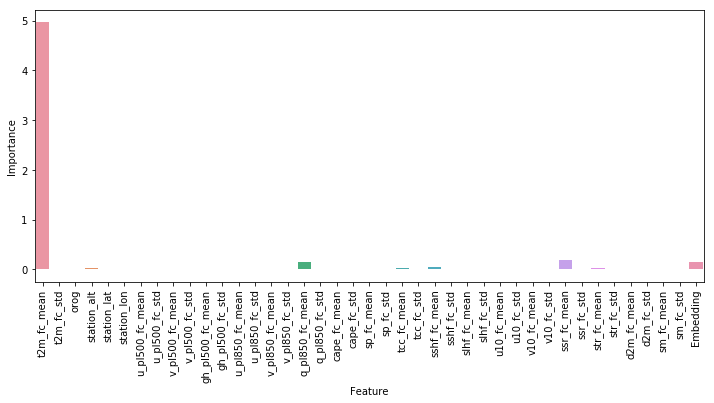

In [20]:
fig, ax = plt.subplots(figsize=(12, 5))
sns.barplot(data=fimp_fc_aux_emb, y='Importance', x='Feature', ax=ax)
plt.xticks(rotation=90);

## Neural net with hidden layer and embeddings

This is our best configuration for one year of data.

### Train the model

In [21]:
nn_aux_emb = build_emb_model(n_features, 2, [50], emb_size, max_id, compile=True, lr=0.01)

In [22]:
nn_aux_emb.fit([aux_train_set.features, aux_train_set.cont_ids], aux_train_set.targets, 
               epochs=30, batch_size=1024, verbose=0);

In [23]:
ref_score = nn_aux_emb.evaluate([aux_test_set.features, aux_test_set.cont_ids], aux_test_set.targets, 4096, 0)
ref_score

0.90673100646545524

### Evaluate feature importance

In [24]:
fimp_nn_aux_emb = perm_imp_emb(nn_aux_emb, ref_score)

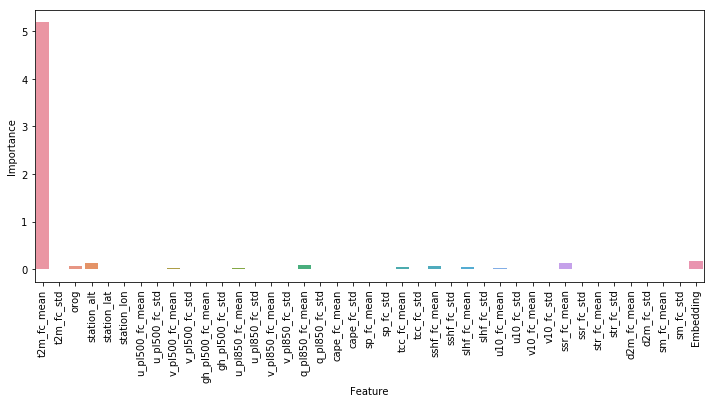

In [25]:
fig, ax = plt.subplots(figsize=(12, 5))
sns.barplot(data=fimp_nn_aux_emb, y='Importance', x='Feature', ax=ax)
plt.xticks(rotation=90);

## Compare feature importances

In [43]:
fimp_fc_aux = fimp_fc_aux.append({'Feature': 'Embedding'}, ignore_index=True)

In [44]:
fimps = [fimp_fc_aux, fimp_fc_aux_emb, fimp_nn_aux_emb]

In [45]:
comb_df = pd.DataFrame(data=fimp_fc_aux['Feature']); comb_df.head()

,Feature
0,t2m_fc_mean
1,t2m_fc_std
2,orog
3,station_alt
4,station_lat


In [46]:
comb_df['FCN-aux'] = fimp_fc_aux['Importance']
comb_df['FCN-aux-emb'] = fimp_fc_aux_emb['Importance']
comb_df['NN-aux-emb'] = fimp_nn_aux_emb['Importance']

In [47]:
comb_df['Mean importance'] = comb_df.iloc[:, 1:].mean(axis=1)

In [48]:
comb_df.sort_values('Mean importance', ascending=False, inplace=True)

In [49]:
comb_df.head()

,Feature,FCN-aux,FCN-aux-emb,NN-aux-emb,Mean importance
0,t2m_fc_mean,4.895131,4.967867,5.189223,5.017407
40,Embedding,NaN,0.154312,0.174593,0.164453
32,ssr_fc_mean,0.169814,0.189118,0.122196,0.160376
3,station_alt,0.270703,0.024043,0.127634,0.140793
16,q_pl850_fc_mean,0.141714,0.142123,0.097032,0.126956


In [50]:
len(fimp_fc_aux)

42

In [51]:
comb_df.sum()

Feature            t2m_fc_meanEmbeddingssr_fc_meanstation_altq_pl...
FCN-aux                                                      5.79921
FCN-aux-emb                                                  5.63386
NN-aux-emb                                                   6.09812
Mean importance                                              5.89855
dtype: object

In [52]:
comb_df.iloc[0, 1:] /= 10

In [53]:
comb_df['Feature'].iloc[0] = 't2m_mean / 10'

/Users/stephanrasp/anaconda/envs/py36_keras/lib/python3.6/site-packages/pandas/core/indexing.py:179: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


In [54]:
melt_df = comb_df.iloc[:15, :4].melt(id_vars='Feature', var_name='Experiment', value_name='Importance')

In [55]:
melt_df['Feature'] = [f.replace('_fc_', '_') for f in melt_df['Feature']]

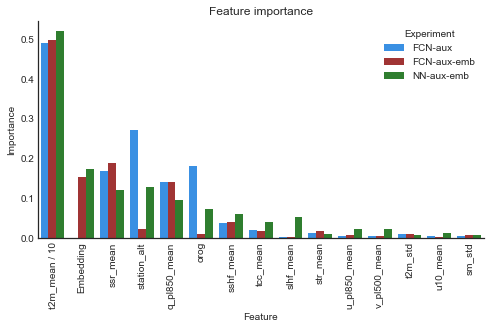

In [56]:
sns.set_style('white')
sns.set_palette(['#1E90FF', '#B22222', '#228B22'])
fig, ax = plt.subplots(figsize=(8, 4))
sns.barplot(data = melt_df, x='Feature', y='Importance', hue='Experiment', ax=ax)
plt.xticks(rotation=90);
sns.despine()
plt.title('Feature importance');

In [57]:
fig.savefig('./feature-importance.pdf', bbox_inches='tight')

## Why is t2m_std not important?

### Is there a good correlation between forecast error and raw ansemble spread?

In [106]:
fc_err = aux_test_set.features[:, 0] * aux_test_set.scale_factors[0] - aux_test_set.targets
ens_spread = aux_test_set.features[:, 1] * aux_test_set.scale_factors[1]

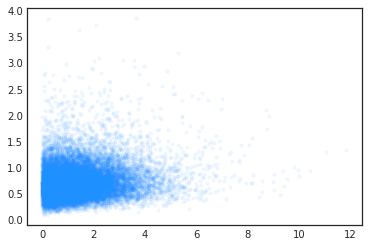

In [113]:
plt.scatter(np.abs(fc_err[::10]), ens_spread[::10], alpha=0.05, s=10);

In [128]:
np.corrcoef(np.abs(fc_err), ens_spread)[0, 1]

0.1512493250576319

In [132]:
np.abs(fc_err).mean(), ens_spread.mean(), ens_spread.mean()/np.abs(fc_err).mean()

(1.4406393, 0.7327051, 0.5085972)

### What about the correlation between the error and PP spread?

In [116]:
preds = nn_aux_emb.predict([aux_test_set.features, aux_test_set.cont_ids], 4096, 0)

In [120]:
pp_spread = np.abs(preds[:, 1])

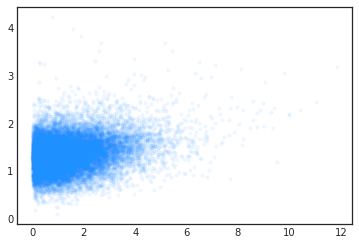

In [121]:
plt.scatter(np.abs(fc_err[::10]), pp_spread[::10], alpha=0.05, s=10);

In [127]:
np.corrcoef(np.abs(fc_err), pp_spread)[0, 1]

0.2527952174715911

In [133]:
pp_spread.mean()/np.abs(fc_err).mean()

0.9474062

### Does the NN care at all about the fc spread?

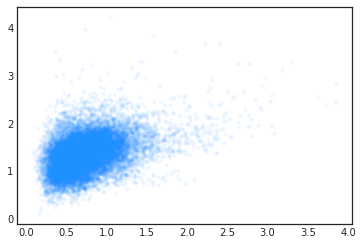

In [124]:
plt.scatter(ens_spread[::10], pp_spread[::10], alpha=0.05, s=10);

In [129]:
np.corrcoef(ens_spread, pp_spread)[0, 1]

0.39276360174270497

In [126]:
np.mean(pp_spread), np.mean(ens_spread)

(1.3648705, 0.7327051)